# Amy Hatman
# Milestone 5
# March 2, 2024

In [1]:
# importing needed packages
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from __future__ import print_function
import time
import cfbd
import json
from cfbd.rest import ApiException
from pandas import json_normalize
import sqlite3
import matplotlib.pyplot as plt

In [2]:
# Bringing in my CSV data and cleaning it (milestone 2)
NFL_score_stats = pd.read_csv("NFL Player Stats(1922 - 2022).csv")

NFL_score_stats = NFL_score_stats.drop(columns=['Unnamed: 0', 'XPM', 'XPA', 'FGM', 'FGA'])

def add_year(x):
    return x + 1

old_season = NFL_score_stats['Season']
new_season = old_season.apply(add_year)
NFL_score_stats['Season'] = new_season

NFL_score_stats = NFL_score_stats.rename(columns={'Season': 'Season End', 'Tm': 'Team', 'G': 'Games', 'PR TD': 'Punt Return TD', 'KR TD': 'Kick Return TD', 'FblTD': 'Fumble TD', 'IntTD': 'Intercept TD', 'Pts': 'Points Total'})

NFL_score_stats = NFL_score_stats.drop(NFL_score_stats[NFL_score_stats['Season End'] <= 1999].index)

winners = ['Ron Dayne', 'Chris Wienke', 'Eric Crouch', 'Carson Palmer', 'Jason White', 'Mmatt Leinhart', 'Reggie Bush', 'Troy Smith', 'Tim Tebow', 'Sam Bradford', 'Mark Ingram Jr.', 'Cam Newton', 'Robert Griffin III', 'Johnny Manziel', 'Jameis Winston', 'Marcus Mariota', 'Derrick Henry', 'Lamar Jackson', 'Baker Mayfield', 'Kyler Murray', 'Joe Burrow', 'DeVonta Smith', 'Bryce Young']
NFL_score_stats = NFL_score_stats.loc[NFL_score_stats['Player'].isin(winners)].reset_index(drop=True)
NFL_score_stats.head()

,Season End,Player,Team,Age,Pos,Games,GS,RshTD,RecTD,Punt Return TD,...,Fumble TD,Intercept TD,OthTD,AllTD,2PM,2PA,D2P,Sfty,Points Total,Pts/G
0,2001,Ron Dayne,NYG,22.0,RB,16.0,4.0,5.0,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,30.0,1.9
1,2002,Ron Dayne,NYG,23.0,RB,16.0,7.0,7.0,NaN,NaN,...,NaN,NaN,NaN,7.0,1.0,NaN,NaN,NaN,44.0,2.8
2,2003,Ron Dayne,NYG,24.0,RB,16.0,1.0,3.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,18.0,1.1
3,2005,Ron Dayne,NYG,26.0,RB,14.0,2.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,6.0,0.4
4,2005,Carson Palmer,CIN,25.0,QB,13.0,13.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,6.0,0.5


In [3]:
# Bringing in my Wesbite data and cleaning it (milestone 3)
fd = open("Heisman Records & Statistics - Heisman.htm", "r", encoding='utf-8')
soup = BeautifulSoup(fd)
fd.close()

tables = soup.find_all("table")
passing = None
for table in tables:
    if "Passing" in table.get_text():
        passing = table

if passing:
    data = []
    headers = [header.text.strip() for header in passing.find_all('th')]
    for row in passing.find_all('tr'):
        cells = row.find_all('td')
        if cells:
            cells = [cell.text.strip() for cell in cells]
            data.append(cells)
            
heisman_df = pd.DataFrame(data)

headers = heisman_df.iloc[0]
heisman_df = heisman_df[1:]
heisman_df.columns = headers

heisman_df[['Player', 'College']] = heisman_df.Player.str.split(',', expand=True)

col = heisman_df.pop('College')
heisman_df.insert(1, 'College', col)

heisman_df['Passing'] = heisman_df['Passing'].astype(int)
heisman_df['Rushing'] = heisman_df['Rushing'].astype(int)
heisman_df['Receiving'] = heisman_df['Receiving'].astype(int)
heisman_df['Returns'] = heisman_df['Returns'].astype(int)
heisman_df['Total'] = heisman_df['Total'].astype(int)
heisman_df['Year'] = heisman_df['Year'].astype(int)

heisman_df['Passing Points'] = heisman_df['Passing'] * 6
heisman_df['Rushing Points'] = heisman_df['Rushing'] * 6
heisman_df['Receiving Points'] = heisman_df['Receiving'] * 6
heisman_df['Returns Points'] = heisman_df['Returns'] * 6
heisman_df['Total Points'] = heisman_df['Total'] * 6
heisman_df.head()

heisman_df = heisman_df.drop(columns=['Passing', 'Rushing', 'Receiving', 'Returns', 'Total'])

heisman_df = heisman_df.drop(heisman_df[heisman_df['Year'] <= 1998].index)
heisman_df.head()

,Player,College,Year,Passing Points,Rushing Points,Receiving Points,Returns Points,Total Points
1,Sam Bradford,Oklahoma,2008,288,30,0,0,318
2,Marcus Mariota,Oregon,2014,228,84,6,0,318
3,Lamar Jackson,Louisville,2016,180,126,0,0,306
4,Joe Burrow,LSU,2019,288,18,0,0,306
5,Kyler Murray,Oklahoma,2018,240,66,0,0,306


In [4]:
# and finally calling my api and cleaning the data (milestone 4)
configuration = cfbd.Configuration()
json_file_path = "CFBDKey.json"
with open(json_file_path, "r") as file:
    api_key_data = json.load(file)
api_key = api_key_data["CFBD_key"]
configuration.api_key['Authorization'] = api_key
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_instance = cfbd.DraftApi(cfbd.ApiClient(configuration))

all_data = []
for year in range(1999, 2023):
    try:
        api_response = api_instance.get_draft_picks(year=year)
        for draft_pick in api_response:
            data = {
                'college_athlete_id': draft_pick.college_athlete_id,
                'nfl_athlete_id': draft_pick.nfl_athlete_id,
                'college_id': draft_pick.college_id,
                'college_team': draft_pick.college_team,
                'college_conference': draft_pick.college_conference,
                'nfl_team': draft_pick.nfl_team,
                'year': draft_pick.year,
                'overall': draft_pick.overall,
                'round': draft_pick.round,
                'pick': draft_pick.pick,
                'name': draft_pick.name,
                'position': draft_pick.position,
                'height': draft_pick.height,
                'weight': draft_pick.weight,
                'pre_draft_ranking': draft_pick.pre_draft_ranking,
                'pre_draft_position_ranking': draft_pick.pre_draft_position_ranking,
                'pre_draft_grade': draft_pick.pre_draft_grade,
                'hometown_info': draft_pick.hometown_info}
            all_data.append(data)
        time.sleep(1)
        
    except ApiException as e:
        print("Exception when calling DraftApi->get_draft_picks:", e)

draft_data = pd.DataFrame(all_data)

draft_data = draft_data.drop(columns=['college_athlete_id', 'nfl_athlete_id',
                                      'college_id', 'height', 'weight', 'pre_draft_ranking',
                                     'pre_draft_position_ranking', 'pre_draft_grade', 'hometown_info'])

draft_data = draft_data.rename(columns={'college_team': 'College', 'college_conference': 'College Conference',
                                        'nfl_team': 'NFL Team', 'year': 'Draft Year', 'overall': 'Overall Pick',
                                        'round': 'Draft Round', 'pick': 'Draft Pick', 'name': 'Player', 'position': 'Position'})

draft_data = draft_data.loc[draft_data['Player'].isin(winners)].reset_index(drop=True)

team_mapping = {'New York': 'NYG', 'Philadelphia': 'PHI', 'Cincinnati': 'CIN',
                'New Orleans': 'NOR', 'Baltimore': 'BAL', 'Los Angeles': 'LAR',
                'Denver': 'DEN', 'Carolina': 'CAR', 'Washington': 'WAS', 'Cleveland': 'CLE',
                'Arizona': 'ARI', 'Tennessee': 'TEN', 'Tampa Bay': 'TAM'}
for old_name, new_name in team_mapping.items():
    draft_data.loc[draft_data['NFL Team'] == old_name, 'NFL Team'] = new_name

pos_mapping = {'Wide Receiver': 'WB', 'Quarterback': 'QB', 'Running Back': 'RB'}
for old_name, new_name in pos_mapping.items():
    draft_data.loc[draft_data['Position'] == old_name, 'Position'] = new_name

col = draft_data.pop('Player')
draft_data.insert(0, 'Player', col)
draft_data.head()

,Player,College,College Conference,NFL Team,Draft Year,Overall Pick,Draft Round,Draft Pick,Position
0,Troy Smith,East Carolina,Conference USA,PHI,1999,201,6,32,WB
1,Ron Dayne,Wisconsin,Big Ten,NYG,2000,11,1,11,RB
2,Eric Crouch,Nebraska,Big 12,LAR,2002,95,3,30,WB
3,Carson Palmer,USC,Pac-10,CIN,2003,1,1,1,QB
4,Reggie Bush,USC,Pac-10,NOR,2006,2,1,2,RB


In [5]:
# load the files into a SQLite database
connect = sqlite3.connect('football_database.db')
cursor = connect.cursor()

In [6]:
# Convert the dataframes to SQLite tables
NFL_score_stats.to_sql('NFL_score_stats', connect, if_exists='replace')
heisman_df.to_sql('heisman_df', connect, if_exists='replace')
draft_data.to_sql('draft_data', connect, if_exists='replace')

19

In [7]:
# Now joining them all based on player name
query = """
    SELECT 
        NFL_score_stats.*,
        heisman_df.College AS College, 
        heisman_df.Year AS Heisman_Year, 
        heisman_df.[Passing Points] AS Passing_Points, 
        heisman_df.[Rushing Points] AS Rushing_Points, 
        heisman_df.[Receiving Points] AS Receiving_Points, 
        heisman_df.[Returns Points] AS Returns_Points, 
        heisman_df.[Total Points] AS Total_Points,
        draft_data.[College Conference] AS College_Conference, 
        draft_data.[NFL Team] AS NFL_Team, 
        draft_data.[Draft Year] AS Draft_Year, 
        draft_data.[Overall Pick] AS Overall_Pick, 
        draft_data.[Draft Round] AS Draft_Round, 
        draft_data.[Draft Pick] AS Draft_Pick, 
        draft_data.Position AS Draft_Position
    FROM 
        NFL_score_stats
    LEFT JOIN 
        heisman_df ON NFL_score_stats.Player = heisman_df.Player
    LEFT JOIN 
        draft_data ON NFL_score_stats.Player = draft_data.Player
"""

In [8]:
# running my query
cursor.execute(query)
combined = cursor.fetchall()
columns = [col[0] for col in cursor.description]
# making the data a data frame
all_data = pd.DataFrame(combined, columns=columns)
# closing connection
connect.close()

In [9]:
all_data.head()

,index,Season End,Player,Team,Age,Pos,Games,GS,RshTD,RecTD,...,Receiving_Points,Returns_Points,Total_Points,College_Conference,NFL_Team,Draft_Year,Overall_Pick,Draft_Round,Draft_Pick,Draft_Position
0,0,2001,Ron Dayne,NYG,22.0,RB,16.0,4.0,5.0,NaN,...,0.0,0.0,120.0,Big Ten,NYG,2000,11,1,11,RB
1,1,2002,Ron Dayne,NYG,23.0,RB,16.0,7.0,7.0,NaN,...,0.0,0.0,120.0,Big Ten,NYG,2000,11,1,11,RB
2,2,2003,Ron Dayne,NYG,24.0,RB,16.0,1.0,3.0,NaN,...,0.0,0.0,120.0,Big Ten,NYG,2000,11,1,11,RB
3,3,2005,Ron Dayne,NYG,26.0,RB,14.0,2.0,1.0,NaN,...,0.0,0.0,120.0,Big Ten,NYG,2000,11,1,11,RB
4,4,2005,Carson Palmer,CIN,25.0,QB,13.0,13.0,1.0,NaN,...,0.0,0.0,216.0,Pac-10,CIN,2003,1,1,1,QB


## Plot #1

My first plot is a simple bar plot to find the highest scoring position. I used the position the player was listed as during the draft from my API data and the Points Total column from their NFL score stats from the CSV data.

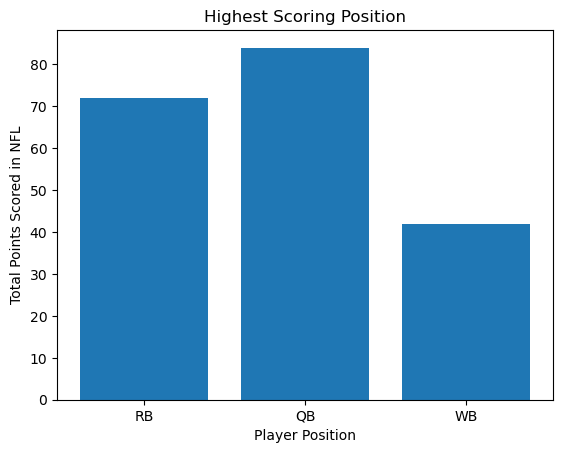

In [10]:
# setting my x and y for the plot
x = all_data['Draft_Position']
y = all_data['Points Total']

# plotting and labeling
plt.bar(x, y)
plt.xlabel("Player Position")
plt.ylabel("Total Points Scored in NFL")
plt.title("Highest Scoring Position")
plt.show()

From this bar graph we can see that Quaterbacks are the highest scoring Heisman Winners in the NFL. This is actually suprising to me!

## Plot #2

Next I plotted the draft pick positions. Heisman winners are touted as being the best in their class, so we would expect most if not all to be the #1 overall pick or very close.

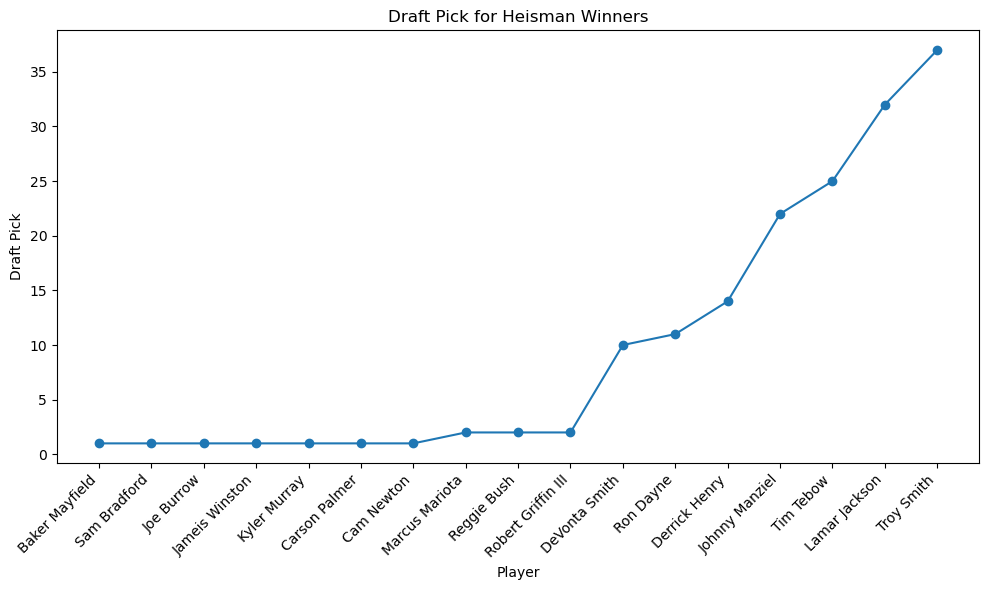

In [11]:
# Setting my plot
plt.figure(figsize=(10, 6))

# Sorting by player and season end 
all_data_sorted = all_data.sort_values(by=['Player', 'Season End'])

# grouping by player and only the first season of the NFL
first_season = all_data_sorted.groupby('Player').first().reset_index()

# creating a variable of the data sorted by draft pick
first_season_sorted = first_season.sort_values(by='Draft_Pick')

# plotting the data and labeling
plt.plot(first_season_sorted['Player'], first_season_sorted['Draft_Pick'], marker='o', linestyle='-')
plt.xlabel("Player")
plt.ylabel("Draft Pick")
plt.title("Draft Pick for Heisman Winners")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the plot, we see that about half were #1 or close, but the other half were much farther down on the pick list.

## Plot #3

My next plot is to compare the players scores the year they won the Heisman versus their first year in the NFL. This uses data from the CSV and Website data.

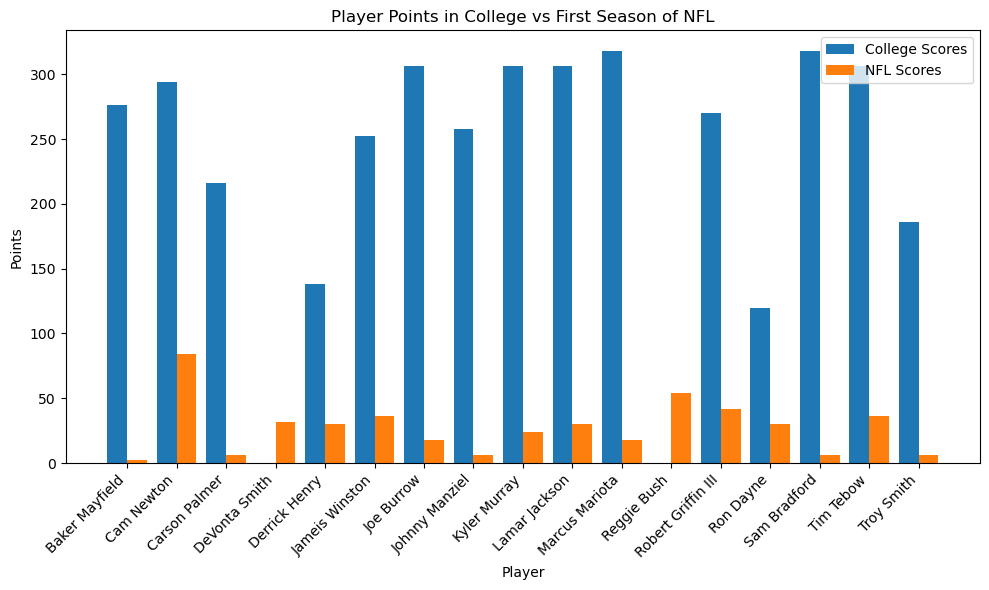

In [12]:
plt.figure(figsize=(10, 6))

# getting data for the plot
X = first_season['Player']
college = first_season['Total_Points']
nfl = first_season['Points Total']

# X axis values
X_axis = np.arange(len(first_season))

# Plotting it
plt.bar(X_axis - 0.2, college, 0.4, label='College Scores')
plt.bar(X_axis + 0.2, nfl, 0.4, label='NFL Scores')

# Formatting x axis labels for readability
plt.xticks(X_axis, X, rotation=45, ha='right')

# adding other labels
plt.xlabel("Player")
plt.ylabel("Points")
plt.title("Player Points in College vs First Season of NFL")
plt.legend()
plt.tight_layout()
plt.show()

From the resulting plot, we see that the players scored much higher in College than in the NFL. 

## Plot #4

Next, I wanted to see how just the #1 draft picks performed in the NFL. So I pulled only the #1 overall picks.

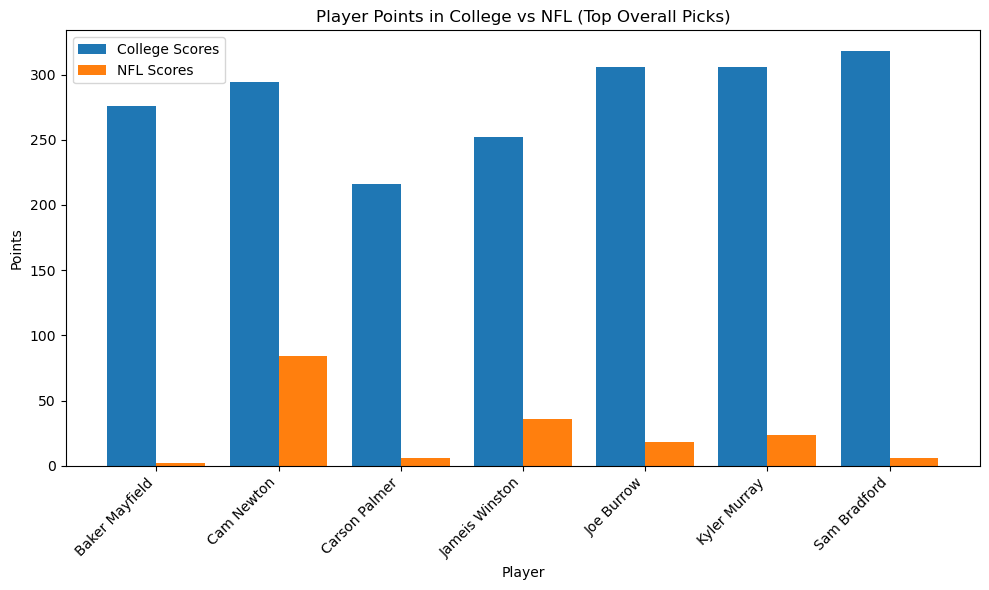

In [13]:
# selecting only those with a 1 for overall pick
first_season_top_picks = first_season[first_season['Overall_Pick'] == 1]
plt.figure(figsize=(10, 6))

# getting data for the plot
X = first_season_top_picks['Player']
college = first_season_top_picks['Total_Points']
nfl = first_season_top_picks['Points Total']

# X axis values
X_axis = np.arange(len(first_season_top_picks))

# Plotting it
plt.bar(X_axis - 0.2, college, 0.4, label='College Scores')
plt.bar(X_axis + 0.2, nfl, 0.4, label='NFL Scores')

# Formatting x axis labels for readability
plt.xticks(X_axis, X, rotation=45, ha='right')

# adding other labels
plt.xlabel("Player")
plt.ylabel("Points")
plt.title("Player Points in College vs NFL (Top Overall Picks)")
plt.legend()
plt.tight_layout()
plt.show()

For being a #1 pick, the scores listed seem pretty low for the majority of the players. 

## Plot #5

The scores for our #1 picks in the NFL seemed low, so next I wanted to see how many games each player played in their first season. This could explain the lower score comparisons. 

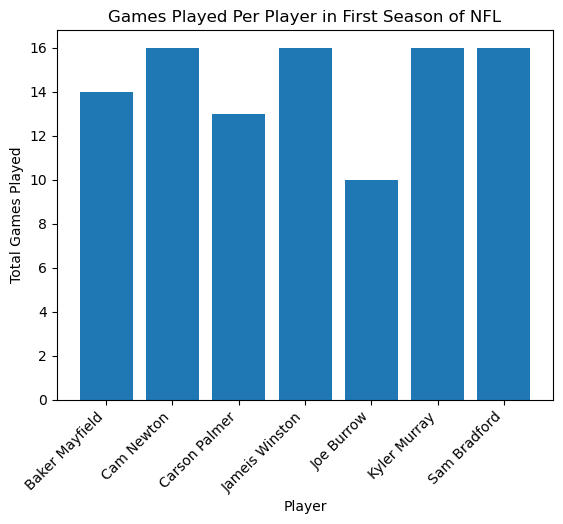

In [14]:
# setting my x and y for the plot
x = first_season_top_picks['Player']
y = first_season_top_picks['Games']

# plotting and labeling
plt.bar(x, y)
X_axis = np.arange(len(first_season_top_picks))
plt.xticks(X_axis, x, rotation=45, ha='right')
plt.xlabel("Player")
plt.ylabel("Total Games Played")
plt.title("Games Played Per Player in First Season of NFL")
plt.show()

As we can see, the majority did indeed play in most if not all games in the season. 

## Summary

   I found this project very enlightening and informative. Taking data from multiple locations and types (CSV, website, and API), cleansing the data, and then compiling them together into one will be vital to my future roll as a Data Scientist.
   
   For this project, I used several methods of wrangling the data including removing columns, replacing Nulls/NaNs, renaming columns, creating new columns calculated based on data in other columns, reordering columns, and more in order to have clean, usuable data. In all, I took a total of 34,117 rows and 51 columns and cleaned/wrangled it down to 83 rows and 36 columns!
    
  I learned quite a bit with this project and felt it was a real-world example of projects that will be done in my career. The use of APIs are frequent as is webscraping to pull needed data. These were relatively new concepts that I had little experience in. This project taught me much on the methods and complications that can arise in performing these methods of extracting data. While I was somewhat lucky and my data was not horribly messy, I also learned that even "clean" data will need wrangling to prepare for analysis on the given topic. From renaming columns, reordering columns, and deleting unnecessary data to creating new columns and rows, there is always something that will likely need to be done when starting a data project.
    
  Ethically, I found no issues with the data wrangling performed or the purpose of the analysis. The information pulled is publically available and often discussed on sports channels during football season. No personal or private information was used. The data wrangling performed would not bias the analysis as the vast majority of steps taken were to remove irrelevant data, non-Heisman winners, or format the data for readability and usability. 